In [1]:
library(tidyverse)
library(readxl)
library(vcfR)
library(VariantAnnotation)
library(rtracklayer)
library(Biostrings)
library(Rsamtools)

data = read_csv("../data/annotated-calls.csv")
data = data %>% filter(AF < 0.40, Dx != "ASD")
cov_info = read_tsv("../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")

## filter outlier
# data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplic

In [2]:
make_vcf <- function(data){
    c <- paste0("chr",data$CHROM)
    s <- data$POS 
    e <- as.integer(s+sapply(as.character(data$REF),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$REF)
    alt(v) <- DNAStringSetList(lapply(data$ALT, function(x){x}))
    mcols(v)$subject = data$`Individual ID`
    mcols(v)$VAF = data$AF
    return(v)
}

v_all = make_vcf(data)
v_scz = make_vcf(data %>% filter(Dx=="SCZ"))
v_ctrl = make_vcf(data %>% filter(Dx!= "SCZ"))

seqlevelsStyle(v_scz) <- "UCSC"
seqlevelsStyle(v_ctrl) <- "UCSC"


In [3]:
## Get all the TF sites
tf_files = system("ls ../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]

[1] 138

In [4]:
## Get all the transcript start sites
library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
gene_names <- read_csv("../resources/genes_matrix_csv/rows_metadata.csv")
listMarts(host="grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37)
att <- listAttributes(mart)

transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
      mart    =mart)

library(regioneR)
transcripts.gr <- toGRanges(transcripts)
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")

## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"




Rows: 52376 Columns: 5

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ensembl_gene_id, gene_symbol
dbl (3): row_num, gene_id, entrez_id


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message:
“Ensembl will soon enforce the use of https.
Ensure the 'host' argument includes "https://"”


biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 105
ENSEMBL_MART_SNP,Ensembl Variation 105
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 105


In [5]:
library(plyranges)
library(liftOver)



Attaching package: ‘plyranges’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:VariantAnnotation’:

    select


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:IRanges’:

    slice


The following objects are masked from ‘package:dplyr’:

    between, n, n_distinct


The following object is masked from ‘package:stats’:

    filter


Loading required package: gwascat

gwascat loaded.  Use makeCurrentGwascat() to extract current image.

 from EBI.  The data folder of this package has some legacy extracts.

Loading required package: Homo.sapiens

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:plyranges’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: OrganismDbi

Loading required package: GenomicFeatures

Loading required

## Figure 3A

In [6]:

ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)

Loading required package: BSgenome



In [7]:
library(liftOver)

rate_ratio_base <- function(v_target, b,tf_ranges, d=100, in_tss=FALSE){
    extension = 1
    dinuc_context <- as.character(Biostrings::getSeq(
    BSgenome::getBSgenome(ref_genome),
    seqnames(v_target),
    start(v_target) - extension,
    end(v_target) + extension
    ))

    v_target$dn = dinuc_context
    plus_cg = c("ACG","CCG","GCG","TCG")
    neg_cg = c("CGA","CGC","CGG","CGT")
    
    v_target = v_target %>% filter(!(dn %in% plus_cg | dn %in% neg_cg))
    
    gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19)
    gwide_sites = sum(letterFrequency(gwide.seq,letters = c(b[1],b[3])))
    if(b[1]=="C"){
        gwide_sites = gwide_sites - sum(dinucleotideFrequency(gwide.seq)[,c("CG","GC")])
    }
    base_muts = v_target[ (v_target$REF == b[1] & as.character(unlist(v_target$ALT)) == b[2]) | 
                  (v_target$REF == b[3] & as.character(unlist(v_target$ALT)) == b[4])]
    gwide_muts = length(base_muts)
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                              end=df$transcription_start_site),strand=df$STRAND)
    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
    dhs = rtracklayer::import("../resources/E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs$ntile = ntile(dhs$score, 20)
    dhs = dhs[dhs$ntile==20]
    if(in_tss){
        epi_promoter = tf_ranges %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) %>% reduce_ranges()
    } else{
        epi_promoter = tf_ranges %>% filter_by_overlaps(dhs) %>% reduce_ranges()        
    }
    epi_promoter = resize(epi_promoter, width = d, fix="center")
    
    reg_seqs = getSeq(BSgenome.Hsapiens.UCSC.hg19,epi_promoter)
    reg_sites = sum(letterFrequency(reg_seqs, letters = c(b[1],b[3])))
    if(b[1]=="C"){
        reg_sites = reg_sites - sum(dinucleotideFrequency(reg_seqs)[,c("CG","GC")])
    }
    epi_promoter$intarget = countOverlaps(epi_promoter,base_muts, ignore.strand=TRUE)
    reg_muts = sum(epi_promoter$intarget)
    return(c(reg_muts = reg_muts, gwide_muts=gwide_muts, reg_sites=reg_sites, gwide_sites=gwide_sites))

}


In [8]:
## Get the rate ratios for SCZ

base_list = list(c("T","G","A","C"),
                c("C","A","G","T"),
                c("C","G","G","C"),
                c("C","T","G","A"),
                c("T","A","A","T"),
                c("T","C","A","G"))
library(parallel)
get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
        return(rate_ratio_base(granges(v_scz),b, tf_final, 2*x, in_tss=TRUE))
    })
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% data.frame() %>% mutate(muts = reg_muts - c(.$reg_muts[2:length(dist_from_tss)],0))
    stats_df = stats_df %>% mutate(dists = dist_from_tss, RR=0, low_ci=0, high_ci=0, pval=0)
    for(i in 1:nrow(stats_df)){
        res = poisson.test(c(stats_df$muts[i], stats_df$gwide_muts[i]), c(stats_df$reg_sites[i], stats_df$gwide_sites[i]))
        stats_df$RR[i] = res$estimate; stats_df$low_ci[i] = res$conf.int[1]; stats_df$high_ci[i] = res$conf.int[2]
        stats_df$pval[i] = res$p.value
    }
    stats_df$base_change = paste0(b[1], ">",b[2])
    return(stats_df)
}


base_df = lapply(base_list, function(x){ get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T","T>A","T>C","T>G"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100)))

options(repr.plot.width=8, repr.plot.height=4)
p1=full_stat %>% ggplot(aes(x=dists, y=RR)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Binned distance to TFBS + DHS + promoter\nat non-CpG sites",color="Base Change", y="Rate Ratio") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c(
  "#2EBAED", "#000000", "#DE1C14",
  "#D4D2D2", "#ADCC54", "#F0D0CE")) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
full_stat

## Get the rate ratios for SCZ

base_list = list(c("T","G","A","C"),
                c("C","A","G","T"),
                c("C","G","G","C"),
                c("C","T","G","A"),
                c("T","A","A","T"),
                c("T","C","A","G"))
library(parallel)
get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
        return(rate_ratio_base(granges(v_scz),b, tf_final, 2*x, in_tss=FALSE))
    })
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% data.frame() %>% mutate(muts = reg_muts - c(.$reg_muts[2:length(dist_from_tss)],0))
    stats_df = stats_df %>% mutate(dists = dist_from_tss, RR=0, low_ci=0, high_ci=0, pval=0)
    for(i in 1:nrow(stats_df)){
        res = poisson.test(c(stats_df$muts[i], stats_df$gwide_muts[i]), c(stats_df$reg_sites[i], stats_df$gwide_sites[i]))
        stats_df$RR[i] = res$estimate; stats_df$low_ci[i] = res$conf.int[1]; stats_df$high_ci[i] = res$conf.int[2]
        stats_df$pval[i] = res$p.value
    }
    stats_df$base_change = paste0(b[1], ">",b[2])
    return(stats_df)
}


base_df = lapply(base_list, function(x){ get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T","T>A","T>C","T>G"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100)))

options(repr.plot.width=8, repr.plot.height=4)
p2=full_stat %>% ggplot(aes(x=dists, y=RR)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Distance to TFBS + DHS (bp) at non-CpG sites",color="Base Change", y="Rate Ratio") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c(
  "#2EBAED", "#000000", "#DE1C14",
  "#D4D2D2", "#ADCC54", "#F0D0CE")) + 
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
full_stat






reg_muts,gwide_muts,reg_sites,gwide_sites,muts,dists,RR,low_ci,high_ci,pval,base_change
<int>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7,266,24970698,1764610276,1,5000,0.2656663,0.006701215,1.492981,1.948201e-01,T>G
6,266,9251623,1764610276,0,2000,0.0000000,0.000000000,2.663536,6.529721e-01,T>G
6,266,4110636,1764610276,0,1000,0.0000000,0.000000000,5.994700,1.000000e+00,T>G
6,266,1809020,1764610276,2,500,7.3342177,0.883628831,26.755188,3.135593e-02,T>G
4,266,334612,1764610276,4,100,79.3022751,21.449746808,205.438196,2.687104e-07,T>G
5,257,18246688,1069046401,3,5000,0.6839127,0.140118213,2.021219,8.062035e-01,C>A
2,257,7577753,1069046401,1,2000,0.5489376,0.013844708,3.085827,1.000000e+00,C>A
1,257,3994938,1069046401,1,1000,1.0412461,0.026261179,5.853316,6.179973e-01,C>A
0,257,2084449,1069046401,0,500,0.0000000,0.000000000,7.414591,1.000000e+00,C>A


reg_muts,gwide_muts,reg_sites,gwide_sites,muts,dists,RR,low_ci,high_ci,pval,base_change
<int>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
14,266,48731980,1764610276,6,5000,0.8167786,0.297070352,1.8014628,0.8500722053,T>G
8,266,18626546,1764610276,1,2000,0.3561515,0.008983631,2.0014859,0.5367117818,T>G
7,266,8723017,1764610276,1,1000,0.7605022,0.019183044,4.2738388,1.0000000000,T>G
6,266,4065364,1764610276,3,500,4.8954090,1.003179910,14.4622924,0.0247985111,T>G
3,266,768377,1764610276,3,100,25.9008529,5.307669922,76.5177548,0.0002425768,T>G
8,257,33900029,1069046401,5,5000,0.6135266,0.197531604,1.4504211,0.3684909783,C>A
3,257,13895318,1069046401,2,2000,0.5987216,0.072121151,2.1848847,0.7783293694,C>A
1,257,7182468,1069046401,0,1000,0.0000000,0.000000000,2.1518142,0.4254326105,C>A
1,257,3700859,1069046401,1,500,1.1239860,0.028347954,6.3184339,0.5900049665,C>A


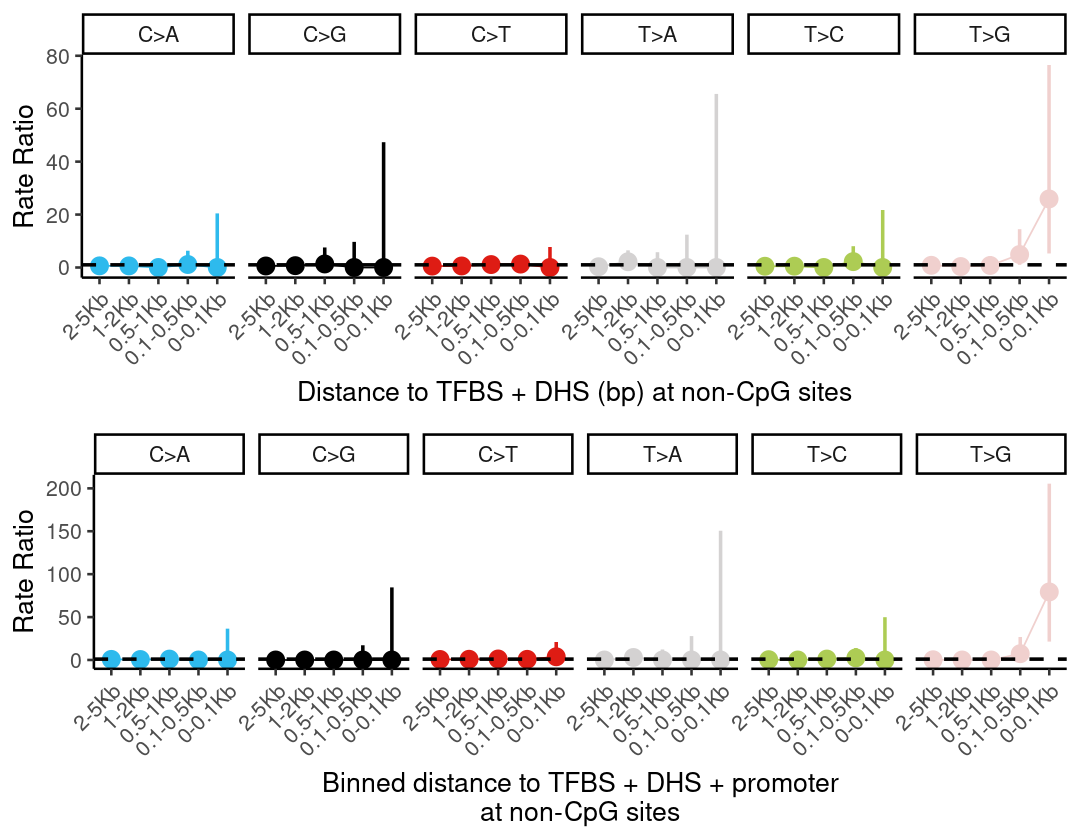

In [9]:
options(repr.plot.width=9, repr.plot.height=7)
p3 = ggpubr::ggarrange(p2,p1, ncol=1, nrow=2)
p3
# ggsave(p3, filename = "../figures/tg_tfbs_dhs_promoter.pdf",device="pdf",width=9,height=7)


## Figure 3B

In [10]:
cts <- read_csv("../resources//genes_matrix_csv/expression_matrix.csv",col_names = FALSE)
gene_names <- read_csv("../resources/genes_matrix_csv/rows_metadata.csv")

cts$gene = gene_names$ensembl_gene_id

agg_counts = aggregate(.~gene, data = cts, sum) %>% tibble::column_to_rownames(var="gene")

## convert rpkm to tpm using http://luisvalesilva.com/datasimple/rna-seq_units.html
tpm_from_rpkm <- function(x) {
  rpkm.sum <- colSums(x)
  return(t(t(x) / (1e-06 * rpkm.sum)))
}

tpm <- tpm_from_rpkm(agg_counts)


## get sample metadata
cts_meta <- read_csv("../resources/genes_matrix_csv/columns_metadata.csv")


# pcw_idx = cts_meta %>% filter(str_detect(age,"pcw"), structure_name == "dorsolateral prefrontal cortex") %>% 
#     pull(column_num)


pcw_idx = cts_meta %>% filter(structure_name == "dorsolateral prefrontal cortex") %>% 
    pull(column_num)

pcw_tpm <- tpm[,pcw_idx]
#pcw_tpm = pcw_tpm[ rowSums(pcw_tpm > 1) > 0,]

median_pcw_tpm = data.frame(gene = rownames(pcw_tpm), value = matrixStats::rowMedians(pcw_tpm,na.rm = TRUE)) 


Rows: 52376 Columns: 525

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (525): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15,...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 52376 Columns: 5

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ensembl_gene_id, gene_symbol
dbl (3): row_num, gene_id, entrez_id


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 524 Columns: 8

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): donor_name, age, gender,

Loading required package: NMF

Loading required package: pkgmaker

Loading required package: registry


Attaching package: ‘pkgmaker’


The following object is masked from ‘package:S4Vectors’:

    new2


Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 27/28

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: ‘NMF’


The following object is masked from ‘package:S4Vectors’:

    nrun


Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 192 Columns: 15

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr  (2): comp.1, offset
dbl (13): comp.2, comp.3, comp.4, comp.5, comp.6, comp.7, comp.8, comp.9, co...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_typ

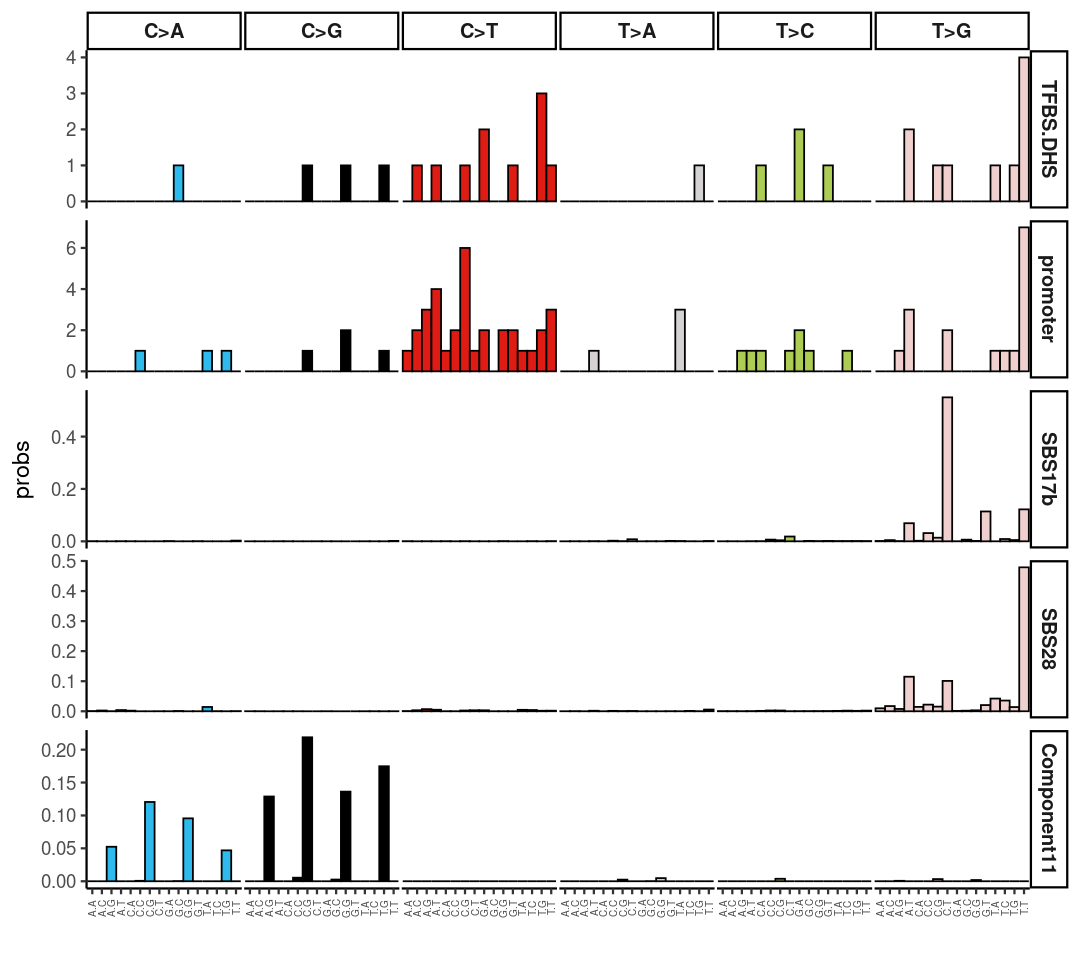

In [11]:
## Vova process
library(MutationalPatterns)
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)

signatures = get_known_signatures()
epimark = rtracklayer::import("../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")

epimark$ntile = ntile(epimark$score, 10)


epimark_top = epimark[epimark$ntile == 10]


v_scz_dhs = granges(v_scz) %>% filter_by_overlaps(epimark_top) %>% filter_by_overlaps(tf_final) 
genome(v_scz_dhs) = "hg19"

df = as.data.frame(transcript.gr)
df$expr = median_pcw_tpm$value[match(df$ensembl_gene_id,median_pcw_tpm$gene)]
df = df %>% mutate(ntile = ntile(expr,2)) %>% filter(ntile == 2)

tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                          end=df$transcription_start_site),
                strand=df$STRAND)

tss.gr = flank(tss.gr, width=2500 + width(tss.gr),start=TRUE)
#tss.gr = c(flank(tss.gr,10000, start=TRUE), flank(tss.gr, 10000, start=FALSE))

h = findOverlaps(v_scz,tss.gr)
v_scz_tss = v_scz[queryHits(h)]
genome(v_scz_tss) = "hg19"

vova_components = read_delim("../resources/Vova_signatures.txt")
odd_bases = c("G>T","G>C","G>A","A>T","A>G","A>C")
comp = list("AA" = "TT", "AC" ="TG", "AG"="TC","AT"="TA",
           "CA" = "")
comp11 = vova_components %>% mutate(base_change = paste0(substr(comp.1,2,2),">",substr(comp.1,5,5))) %>%
    mutate(cnt = paste0(substr(comp.1,1,1),substr(comp.1,3,3)))
# comp11

comp11$rev_cnt = as.character(reverseComplement(DNAStringSet(comp11$cnt)))

odd_bases = c("G>T","G>C","G>A","A>T","A>G","A>C")
comp11 = comp11 %>%
    mutate(base_change2 = ifelse(base_change == "G>T","C>A",base_change)) %>%
    mutate(base_change2 = ifelse(base_change2 == "G>C","C>G",base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 == "G>A", "C>T",base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 == "A>T","T>A", base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 =="A>G","T>C", base_change2)) %>%
    mutate(base_change2 = ifelse(base_change2 == "A>C","T>G",base_change2)) %>%
    mutate(base_change2 = ifelse(base_change %in% odd_bases,
                                 paste0(substr(rev_cnt,1,1),"[",base_change2,"]",substr(rev_cnt,2,2)),
                                paste0(substr(cnt,1,1),"[",base_change2,"]",substr(cnt,2,2)))) %>%
    group_by(base_change2) %>% summarise(component_11 = sum(comp.12))



mut_mat_dhs = mut_matrix(v_scz_dhs, ref_genome=ref_genome)
mut_mat_tss = mut_matrix(granges(v_scz_tss), ref_genome=ref_genome)

# comp11 = comp11[match(rownames(mut_mat_dhs), comp11$base_change),]

mut_mat_scz = data.frame("TFBS.DHS"=mut_mat_dhs[,1], promoter=mut_mat_tss[,1], SBS17b = signatures[,"SBS17b"],
                         SBS28 = signatures[,"SBS28"],
                         tnc=rownames(mut_mat_dhs))

mut_mat_scz$Component11 = comp11$component_11[match(rownames(mut_mat_scz), comp11$base_change2)]


options(repr.plot.width=9, repr.plot.height=8)
p1 = mut_mat_scz %>% mutate(subs =rep(c("C>A","C>G","C>T","T>A","T>C","T>G"),each=16)) %>%
    pivot_longer(cols= c(-tnc,-subs), names_to="sigs", values_to ="probs") %>% 
    mutate(sigs = factor(sigs,levels=c("TFBS.DHS","promoter","SBS17b","SBS28","Component11"))) %>%
                        ggplot(aes(x=tnc, y=probs)) + 
                        geom_bar(aes(fill=subs),color="black",stat="identity",width = 1, show.legend = FALSE) + 
                            facet_grid(sigs~subs, scales="free")+ 
                            theme_classic(14) + 
                            labs(x="") +
                            scale_fill_manual(values = c("#2EBAED", "#000000", "#DE1C14","#D4D2D2", "#ADCC54", "#F0D0CE")) +
                            theme(strip.text = element_text(size= 12, face="bold"), 
                                  axis.text.x = element_text(angle=90,vjust=0.5, size=6),
                                 panel.spacing.x = unit(0.1, "lines"),
                                 panel.grid = element_blank()) +
                            scale_x_discrete(labels= paste(substr(mut_mat_scz$tnc, 1, 1), substr(mut_mat_scz$tnc, 7, 7), sep = "."))
p1

# ggsave(p1, filename = "../figures/trinuc_context.pdf",device="pdf",width=9, height=8)

## Figure 3C

In [12]:
library(MutationalPatterns)
signatures = get_known_signatures()

genome(v_scz) = "hg19"
genome(v_ctrl) = "hg19"

grl = c(SCZ = granges(v_scz),CONT = granges(v_ctrl))


df = as.data.frame(transcript.gr)
df$expr = median_pcw_tpm$value[match(df$ensembl_gene_id,median_pcw_tpm$gene)]
df = df %>% mutate(ntile = ntile(expr,2)) %>% filter(ntile == 2)
tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                          end=df$transcription_start_site),
                strand=df$STRAND)

tss.gr = flank(tss.gr, width=2500 + width(tss.gr),start=TRUE)
# tss.gr = c(flank(tss.gr,10000, start=TRUE), flank(tss.gr, 10000, start=FALSE))



h = findOverlaps(v_scz,tss.gr)
v_scz_tss = v_scz[queryHits(h)]
h = findOverlaps(v_ctrl,tss.gr)
v_ctrl_tss = v_ctrl[queryHits(h)]

length(v_scz_tss)
length(v_ctrl_tss)

genome(v_scz_tss) = "hg19"
genome(v_ctrl_tss) = "hg19"

grl_tss = c(SCZ = granges(v_scz_tss),CONT = granges(v_ctrl_tss))



[1] 68

[1] 13

In [13]:
mut_mat <- mut_matrix(vcf_list = grl, ref_genome = ref_genome)
mut_mat_tss <- mut_matrix(vcf_list = grl_tss, ref_genome = ref_genome)

fit_res = fit_to_signatures(mut_matrix = mut_mat, signatures[,c("SBS1","SBS5","SBS17a","SBS17b")])
fit_res_tss = fit_to_signatures(mut_mat_tss, signatures[,c("SBS1","SBS5","SBS17a","SBS17b")])

In [14]:
fit_res$contribution
fit_res_tss$contribution

,SCZ,CONT
SBS1,458.54671,194.2951
SBS5,1875.43438,671.9118
SBS17a,0.00000,0.0000
SBS17b,31.57838,0.0000


,SCZ,CONT
SBS1,10.749158,2.0543900
SBS5,45.349286,6.3521530
SBS17a,0.000000,0.5412438
SBS17b,5.545105,0.1224921


In [15]:
fisher.test(matrix(c(6,45+11,32,1875+459),nr=2,byrow = T))
fisher.test(matrix(c(0,1+6+2,0,672+194),nr=2,byrow = T))


	Fisher's Exact Test for Count Data

data:  matrix(c(6, 45 + 11, 32, 1875 + 459), nr = 2, byrow = T)
p-value = 0.0003165
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.561625 19.941482
sample estimates:
odds ratio 
   7.79781 



	Fisher's Exact Test for Count Data

data:  matrix(c(0, 1 + 6 + 2, 0, 672 + 194), nr = 2, byrow = T)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   0 Inf
sample estimates:
odds ratio 
         0 


In [16]:
library(ggsci)
p1 = plot_contribution(fit_res$contribution,
  coord_flip = FALSE,
  mode = "relative"
) + labs(title = "All sSNV") + scale_fill_npg()

options(repr.plot.width=6, repr.plot.height=5)

p2 = plot_contribution(fit_res_tss$contribution,
                 coord_flip=FALSE, mode="relative") + labs(title="sSNV at TSS/promoter") + scale_fill_npg()

pX = ggpubr::ggarrange(p1,p2, ncol=2, nrow=1)
# pX

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



In [17]:
mut_mat <- mut_matrix(vcf_list = grl, ref_genome = ref_genome)
mut_mat_tss <- mut_matrix(vcf_list = grl_tss, ref_genome = ref_genome)

fit_res = fit_to_signatures(mut_matrix = mut_mat, signatures[,c("SBS1","SBS5","SBS28")])
fit_res_tss = fit_to_signatures(mut_mat_tss, signatures[,c("SBS1","SBS5","SBS28")])

fit_res$contribution
fit_res_tss$contribution

,SCZ,CONT
SBS1,459.7825,194.405282
SBS5,1819.6480,667.858933
SBS28,116.5499,6.741879


,SCZ,CONT
SBS1,10.86453,2.0378219
SBS5,39.29066,6.6711961
SBS28,14.24889,0.2556201


In [18]:
fisher.test(matrix(c(14,39+11,117,1820+460),nr=2,byrow = T))
fisher.test(matrix(c(0,7+2,7,668+194),nr=2,byrow = T))


	Fisher's Exact Test for Count Data

data:  matrix(c(14, 39 + 11, 117, 1820 + 460), nr = 2, byrow = T)
p-value = 3.586e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.701628 10.368431
sample estimates:
odds ratio 
  5.448828 



	Fisher's Exact Test for Count Data

data:  matrix(c(0, 7 + 2, 7, 668 + 194), nr = 2, byrow = T)
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.00000 77.13732
sample estimates:
odds ratio 
         0 


In [19]:
p1 = plot_contribution(fit_res$contribution,
  coord_flip = FALSE,
  mode = "relative"
) + labs(title = "All sSNV") + scale_fill_npg()

options(repr.plot.width=6, repr.plot.height=5)

p2 = plot_contribution(fit_res_tss$contribution,
                 coord_flip=FALSE, mode="relative") + labs(title="sSNV at TSS/promoter") + scale_fill_npg()

pY= ggpubr::ggarrange(p1,p2, ncol=2, nrow=1)
# pY

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



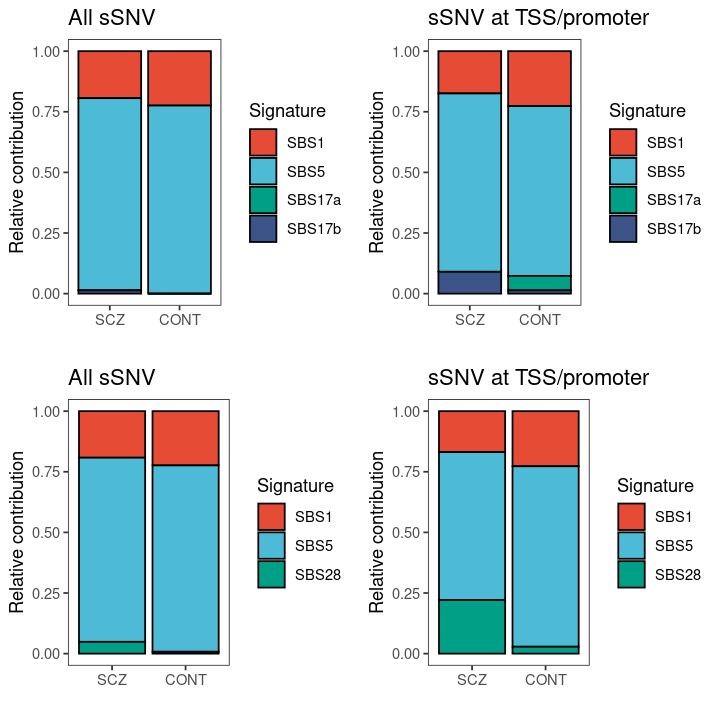

In [20]:
options(repr.plot.width=6, repr.plot.height=6)
pW = ggpubr::ggarrange(pX,pY, ncol=1, nrow=2)
pW
# ggsave(pW, filename = "../figures/sbs17b_sbs28_contribution.pdf",device="pdf", width=6, height=6)

## Figure 3D

In [21]:
# high_TG = data %>% filter(`Individual ID` %in% c("CMC_MSSM_213","CMC_MSSM_224","CMC_MSSM_343"))
# high_TG =split(high_TG, f=high_TG$`Individual ID`)

high_TG = split(data, f=data$`Individual ID`)

v_tg = lapply(high_TG, function(x){
    x = granges(make_vcf(x))
    genome(x) ='hg19'
    return(x)
})

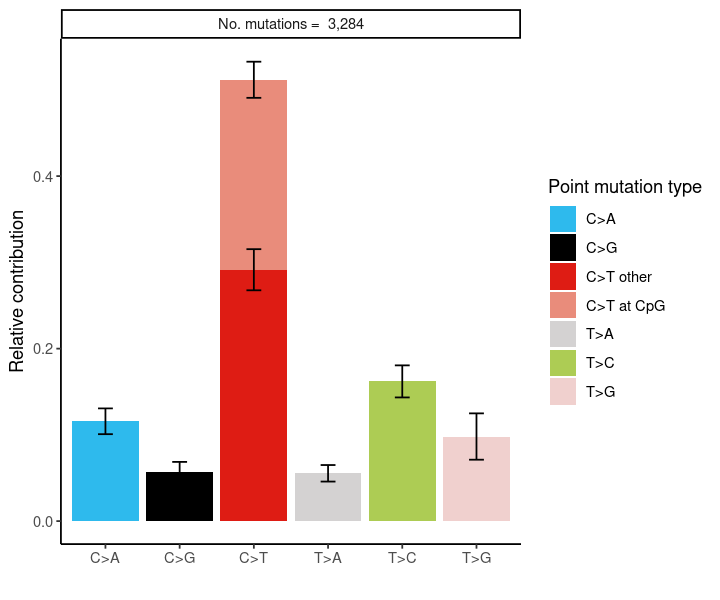

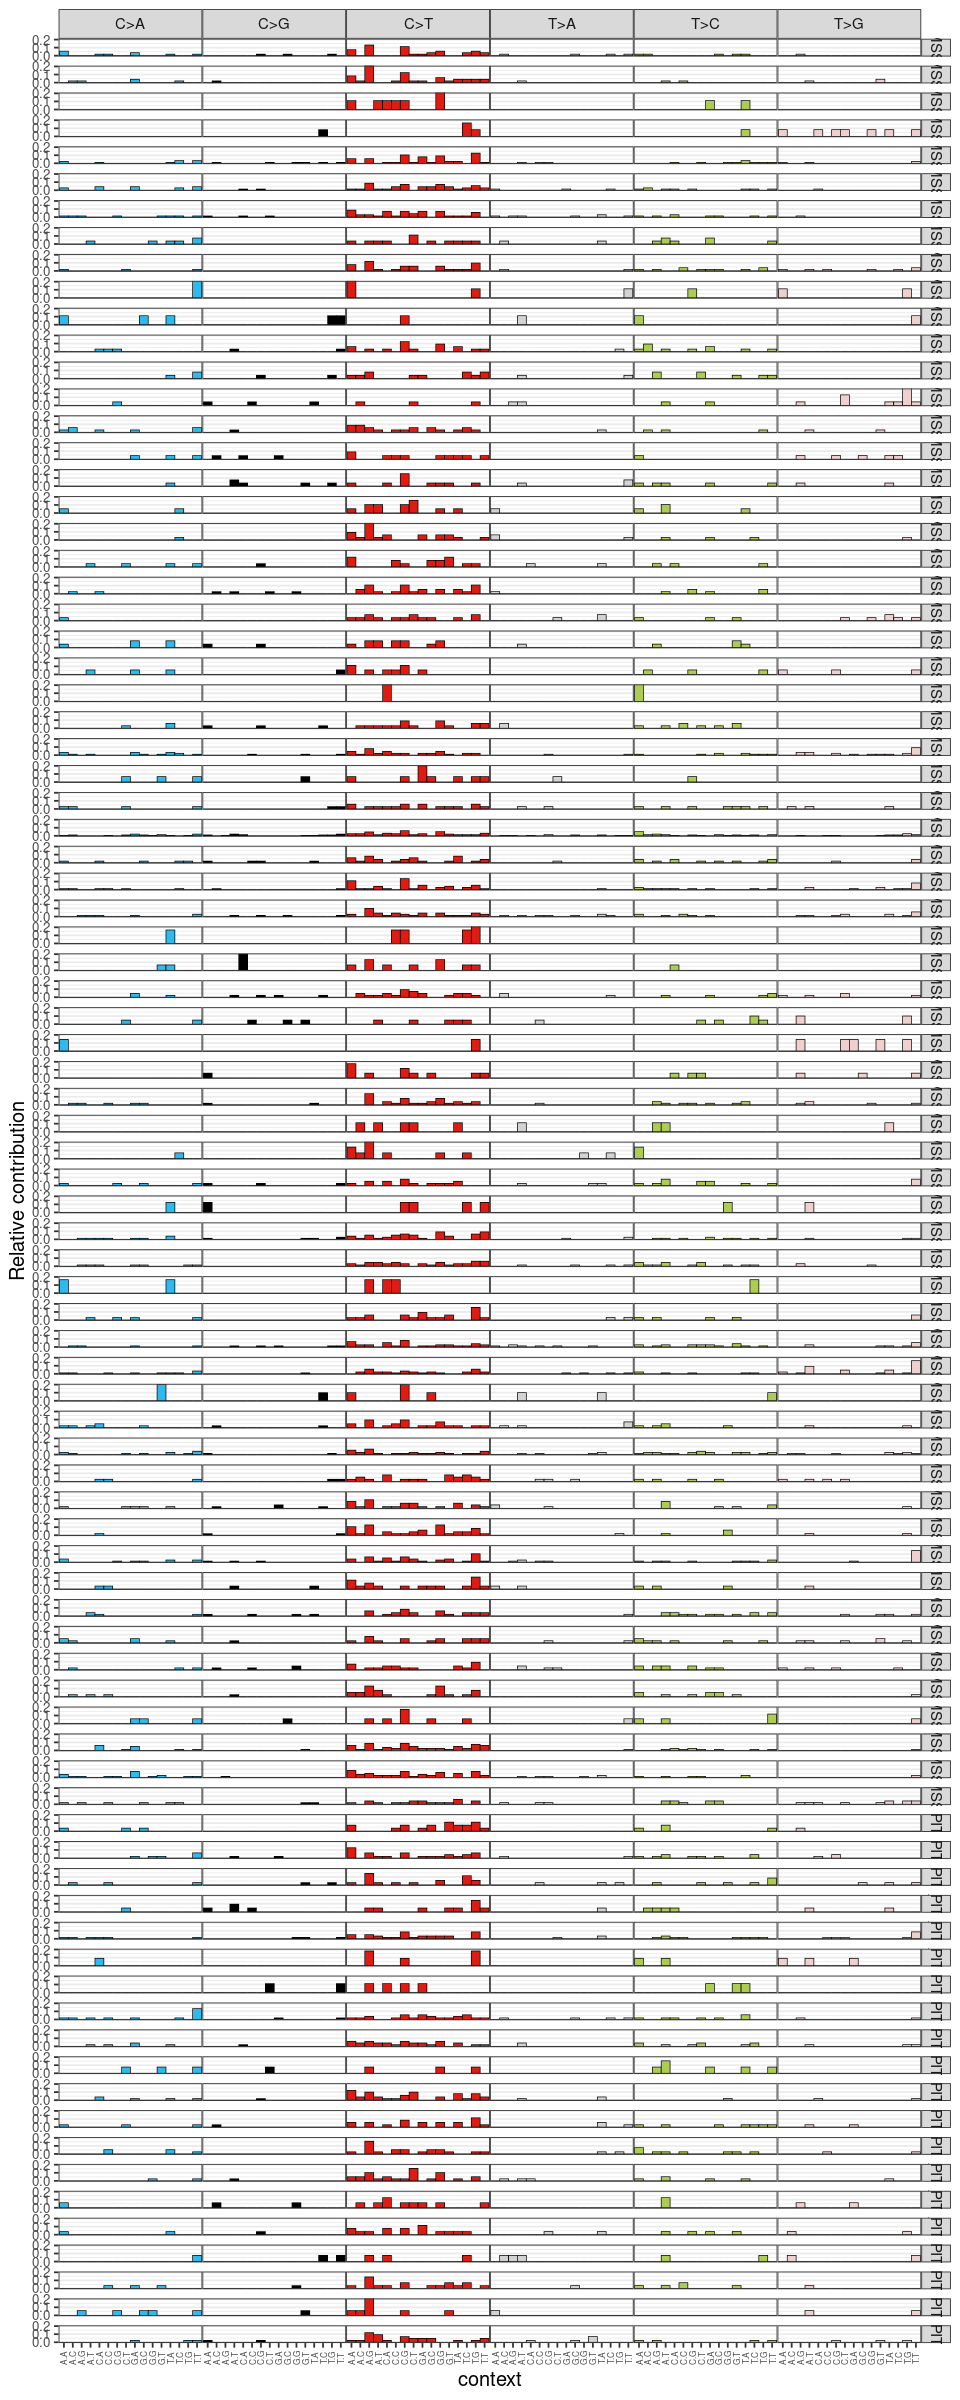

In [22]:
type_occurrences <- mut_type_occurrences(v_tg, ref_genome)
# type_occurrences

options(repr.plot.width=6, repr.plot.height=5)
plot_spectrum(type_occurrences, CT=TRUE) + theme_classic() 

mut_mat <- mut_matrix(vcf_list = v_tg, ref_genome = ref_genome)
options(repr.plot.width=8, repr.plot.height=20)
plot_96_profile(mut_mat,condensed = TRUE) 

In [23]:
signatures = get_known_signatures()

fit_res_17 = fit_to_signatures(mut_matrix = mut_mat, signatures[,c("SBS1","SBS5","SBS17b")])
fit_res_28 = fit_to_signatures(mut_matrix = mut_mat, signatures[,c("SBS1","SBS5","SBS28")])

In [24]:
plot_df = data.frame(sample = colnames(fit_res_17$contribution), SBS17b = fit_res_17$contribution["SBS17b",],
                    SBS28 = fit_res_28$contribution["SBS28",])
plot_df$Dx = data$Dx[match(plot_df$sample, data$`Individual ID`)]

In [25]:
options(repr.plot.width=8, repr.plot.height=4) 
p1= plot_df %>% ggplot(aes(x=reorder(sample, -SBS17b), y=SBS17b)) +
    geom_bar(stat="identity", aes(fill=Dx), alpha=0.8, color="black") +
    theme_classic(16) + theme(axis.text.x = element_blank(), legend.position = "bottom",
                             axis.ticks.x = element_blank()) +
    scale_fill_manual(values = c("darkorange","dodgerblue3")) + 
    labs(x="Samples",y = "SBS17b estimated contribution")
p2 = plot_df %>% ggplot(aes(x=reorder(sample, -SBS28), y=SBS28)) +
    geom_bar(stat="identity", aes(fill=Dx), alpha=0.8, color="black") +
    theme_classic(16) + theme(axis.text.x = element_blank(), legend.position = "bottom",
                             axis.ticks.x = element_blank()) +
    scale_fill_manual(values = c("darkorange","dodgerblue3")) + 
    labs(x="Samples",y = "SBS28 estimated contribution")


In [26]:
options(repr.plot.width=6, repr.plot.height=6) 
p3 = plot_df %>% ggplot(aes(x=SBS17b, y=SBS28))+ geom_point(aes(color=Dx),size=3,alpha=0.5) +
    theme_classic(16) + scale_color_manual(values = c("darkorange","dodgerblue3"))  +
    labs(x="Estimated SBS17b sSNV contribution",y="Estimated SBS28 sSNV contribution",color="Diagnosis") +
    geom_smooth(method="lm", color="black") 

In [27]:
cor.test(x=plot_df$SBS17b,y=plot_df$SBS28, method = "spearman")

Warning message in cor.test.default(x = plot_df$SBS17b, y = plot_df$SBS28, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  plot_df$SBS17b and plot_df$SBS28
S = 24599, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7679248 


In [28]:
t.test(SBS17b ~ Dx, data=plot_df)
t.test(SBS28 ~ Dx, data=plot_df)


	Welch Two Sample t-test

data:  SBS17b by Dx
t = -2.2384, df = 75.956, p-value = 0.02813
alternative hypothesis: true difference in means between group Control and group SCZ is not equal to 0
95 percent confidence interval:
 -1.11366880 -0.06494022
sample estimates:
mean in group Control     mean in group SCZ 
            0.1823651             0.7716696 



	Welch Two Sample t-test

data:  SBS28 by Dx
t = -2.163, df = 70.164, p-value = 0.03395
alternative hypothesis: true difference in means between group Control and group SCZ is not equal to 0
95 percent confidence interval:
 -2.8837314 -0.1170049
sample estimates:
mean in group Control     mean in group SCZ 
            0.6943845             2.1947527 


In [29]:
plot_df %>% filter(SBS17b >= mean(SBS17b) + 2*sd(SBS17b))
plot_df %>% filter(SBS28 >= mean(SBS28) + 2*sd(SBS28))
5/61*100

,sample,SBS17b,SBS28,Dx
,<chr>,<dbl>,<dbl>,<chr>
CMC_MSSM_158,CMC_MSSM_158,5.096191,3.188928,SCZ
CMC_MSSM_265,CMC_MSSM_265,4.100071,7.786091,SCZ
CMC_MSSM_343,CMC_MSSM_343,12.514167,30.780243,SCZ


,sample,SBS17b,SBS28,Dx
,<chr>,<dbl>,<dbl>,<chr>
CMC_MSSM_213,CMC_MSSM_213,2.880008,15.32692,SCZ
CMC_MSSM_343,CMC_MSSM_343,12.514167,30.78024,SCZ
CMC_MSSM_366,CMC_MSSM_366,2.771394,18.85970,SCZ


[1] 8.196721

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



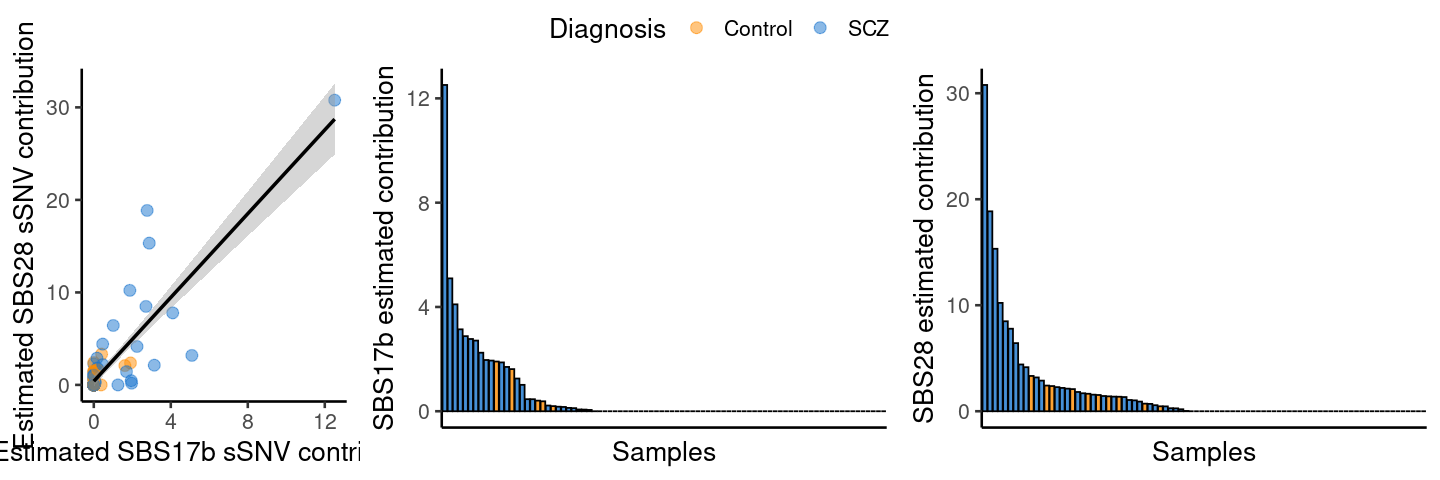

In [30]:
options(repr.plot.width=12, repr.plot.height=4) 
pX = ggpubr::ggarrange(p3,p1,p2, nrow=1, ncol=3,common.legend = TRUE, widths=c(1,1.5,1.5))
pX
# ggsave(pX,filename = "../figures/sbs17_sbs28_corr.pdf",device="pdf",height=4,width=12)

## Figure 3E

Warning message in ks.test(data_tg$VAF, data_non_tg$VAF):
“p-value will be approximate in the presence of ties”



	Two-sample Kolmogorov-Smirnov test

data:  data_tg$VAF and data_non_tg$VAF
D = 0.40913, p-value = 0.001019
alternative hypothesis: two-sided


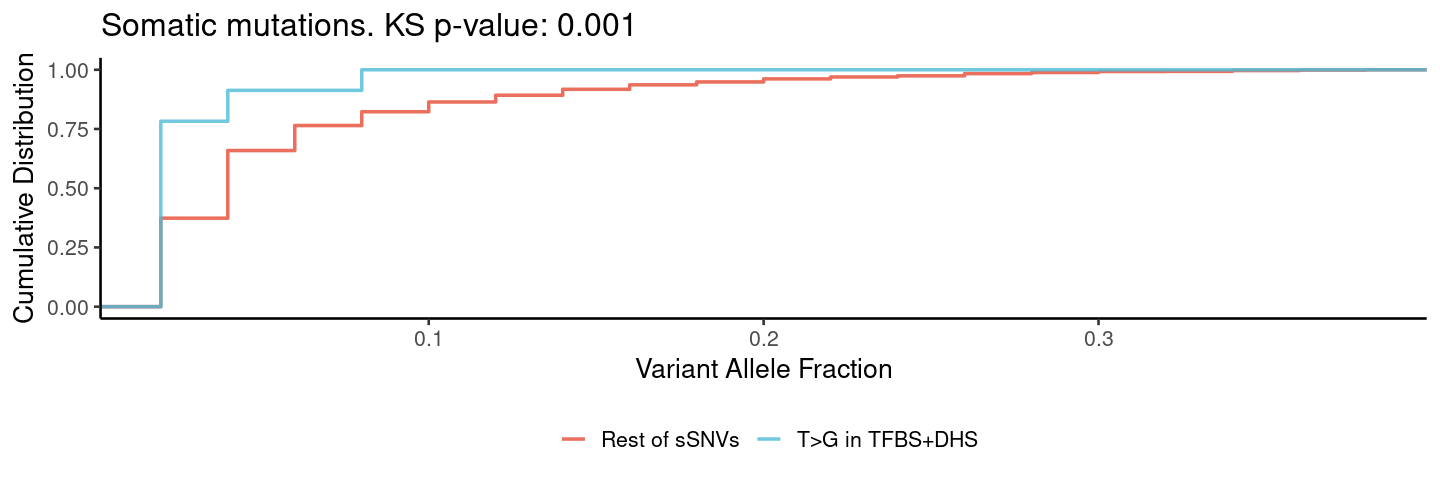

In [31]:
library(ggsci)
# dhs = rtracklayer::import("../resources/dnase_files//fetal_neuron_girkis.bed")
dhs = rtracklayer::import("../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
# dhs$ntile = ntile(dhs$score,2)
# dhs = dhs[dhs$ntile==2]
data_tg = granges(v_scz) %>% filter((REF == "T" & unlist(ALT) == "G") | (REF == "A" & unlist(ALT) == "C")) %>%
    filter_by_overlaps(dhs) %>% filter_by_overlaps(tf_final)
data_non_tg = granges(v_scz) %>% filter((REF != "T" & unlist(ALT) != "G") | (REF != "A" & unlist(ALT) != "C")) %>%
    filter_by_non_overlaps(dhs) %>% filter_by_non_overlaps(tf_final)


plot_df = data.frame(vafs = c(data_tg$VAF, data_non_tg$VAF), inTSS = c(rep("T>G in TFBS+DHS",length(data_tg)),
                                                                  rep("Rest of sSNVs", length(data_non_tg)))) 


k_test = ks.test(data_tg$VAF, data_non_tg$VAF)
k_test



plot_df %>% ggplot(aes(x=vafs)) + stat_ecdf(aes(color=inTSS), lwd=1) + theme_classic(16) + 
    scale_color_npg(alpha=0.8) + 
    labs(title = paste("Somatic mutations. KS p-value:",round(k_test$p.value,4)), color="", 
         x="Variant Allele Fraction",y="Cumulative Distribution") + 
    theme(legend.position = "bottom") 

In [32]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggsci_2.9                              
 [2] MutationalPatterns_3.4.0               
 [3] NMF_0.23.0                             
 [4] cluster_2.1.2                          
 [5] rngtools_1.5.2                         
 [6] pkgmaker_0.32.2                        
 [7] registry_0.5